# Rural road semantic segmentation using Sentinel-2 imagery and U-Net model
Adapted from: https://github.com/usuyama/pytorch-unet


In [1]:
import os
import re
import time
import copy
import random
import math
import glob
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from osgeo import gdal
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
import torch.nn.functional as F

## Get data

In [2]:
!gdown 162Mh5b9PzhjoAUXvD_zd6mCz-HyU-K78

Downloading...
From (original): https://drive.google.com/uc?id=162Mh5b9PzhjoAUXvD_zd6mCz-HyU-K78
From (redirected): https://drive.google.com/uc?id=162Mh5b9PzhjoAUXvD_zd6mCz-HyU-K78&confirm=t&uuid=39603876-7090-486e-81b6-d7a1be34b42f
To: /content/GeoDS.rar
100% 9.91G/9.91G [02:36<00:00, 63.4MB/s]


In [3]:
!unrar x /content/GeoDS.rar

A saída de streaming foi truncada nas últimas 5000 linhas.
Extracting  GeoDS/labels/label__2993.tif                                  99%  OK 
Extracting  GeoDS/labels/label__2994.tif                                  99%  OK 
Extracting  GeoDS/labels/label__2995.tif                                  99%  OK 
...                                  99%  OK 
All OK


In [4]:
# small correction: label idx is displace -1
# run only once
labels_dir = r'/content/GeoDS/labels'
for fn in os.listdir(labels_dir):
    if fn[-3:]=='tif':
        idx = int(re.findall(r'\d+', fn)[-1])
        new_idx = idx+1
        new_fn = 'label_'+str(new_idx)+'.tif'
        os.rename(os.path.join(labels_dir, fn), os.path.join(labels_dir, new_fn))

## Set utils

In [5]:
def gray_to_arr(path):
    '''Open graysclae image and return as np array'''
    raster = gdal.Open(path)
    arr = raster.GetRasterBand(1).ReadAsArray()
    del raster
    return arr


def s2_to_arr(path, bands=['red', 'green', 'blue']):
    '''
    Open Sentinel-2 imagery with specified bands.
    Bands: red, green, blue, nir, swir1, swir2, edge1, edge2, edge3 and edge4.
    Output array has shape (height, width, n_channels)
    '''
    bands_dict = {'blue': 2, 'green': 3, 'red': 4, 'edge1': 5, 'edge2': 6, 'edge3': 7,\
             'nir': 8, 'edge4': 9, 'swir1': 12, 'swir2': 13}

    raster = gdal.Open(path)

    arr = np.dstack(
        [raster.GetRasterBand(bands_dict[band]).ReadAsArray() for band in bands]
    )

    del raster

    return arr


'''
def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()

    intersection = (pred * target).sum(dim=2).sum(dim=2)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))

    return loss.mean()
'''


def dice_loss(pred, target, smooth=1.):
    # Ensure tensors are contiguous
    pred = pred.contiguous()
    target = target.contiguous()

    # If pred or target has fewer than 3 dimensions, add dimensions
    if pred.dim() < 3:
        pred = pred.unsqueeze(1)  # Add a channel dimension if needed
    if target.dim() < 3:
        target = target.unsqueeze(1)  # Add a channel dimension if needed

    # Now the intersection calculation should work
    intersection = (pred * target).sum(dim=1).sum(dim=1) # sum on dim=1 and dim=1 (spatial dimensions)

    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=1).sum(dim=1) + target.sum(dim=1).sum(dim=1) + smooth)))

    return loss.mean() # Average the loss across the batch


def one_hot_encode(in_arr, n_classes=1):
    height, width = in_arr.shape
    out_arr = np.zeros((n_classes, height, width), dtype=in_arr.dtype)
    for class_id in range(n_classes):
        out_arr[class_id] = (in_arr == class_id)

    return out_arr


## Dataset class

In [6]:
class MyDataset(Dataset):
    def __init__(self, root, sample_size=128, samples_range=None, transform=None):
        self.sample_size = sample_size
        self.images_pth = sorted(glob.glob(os.path.join(root, 'images', '*.tif')))
        self.labels_pth = sorted(glob.glob(os.path.join(root, 'labels', '*.tif')))
        assert len(self.images_pth)==len(self.labels_pth), 'N° of images and labels don\'t match'

        # for manual partitioning
        if samples_range:
            i = int(len(self.images_pth)*samples_range[0])
            j = int(len(self.images_pth)*samples_range[1])
            self.images_pth = self.images_pth[i:j]
            self.labels_pth = self.labels_pth[i:j]

        # self.images = np.array([s2_to_arr(pth) for pth in images_pth])
        # self.images = np.transpose(self.images, (3, 2, 0, 1))
        # self.labels = np.array([gray_to_arr(pth) for pth in labels_pth])
        # self.labels = np.transpose(self.labels, (2, 0, 1))

        self.transform = transform


    def __len__(self):
        return len(self.images_pth)


    def __getitem__(self, idx):
        image = s2_to_arr(self.images_pth[idx])
        image = cv2.resize(image, dsize=(self.sample_size, self.sample_size))
        image = np.transpose(image, (2, 0, 1))
        label = gray_to_arr(self.labels_pth[idx])
        label = cv2.resize(label, dsize=(128, 128))
        # label = one_hot_encode(label)
        if self.transform:
            image = self.transform(image)

        return [image, label]


## Model

In [7]:
def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )


class ResNetUNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        self.base_model = models.resnet18(pretrained=True)
        self.base_layers = list(self.base_model.children())

        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)
        self.layer1_1x1 = convrelu(64, 64, 1, 0)
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)
        self.layer2_1x1 = convrelu(128, 128, 1, 0)
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)
        self.layer3_1x1 = convrelu(256, 256, 1, 0)
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)

        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)

        self.conv_last = nn.Conv2d(64, n_class, 1)

    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)

        layer0 = self.layer0(input)
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)
        layer4 = self.layer4(layer3)

        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)

        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)

        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)

        out = self.conv_last(x)

        return out


In [7]:
# model summary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(n_class=2)
model = model.to(device)

# check keras-like model summary using torchsummary
from torchsummary import summary
summary(model, input_size=(3, 128, 128))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 62.6MB/s]


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
              ReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          36,928
              ReLU-4         [-1, 64, 128, 128]               0
            Conv2d-5           [-1, 64, 64, 64]           9,408
            Conv2d-6           [-1, 64, 64, 64]           9,408
       BatchNorm2d-7           [-1, 64, 64, 64]             128
       BatchNorm2d-8           [-1, 64, 64, 64]             128
              ReLU-9           [-1, 64, 64, 64]               0
             ReLU-10           [-1, 64, 64, 64]               0
        MaxPool2d-11           [-1, 64, 32, 32]               0
        MaxPool2d-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
           Conv2d-14           [-1, 64,

## Train routine

In [9]:
def calc_loss(pred, target, metrics, bce_weight=0.5):
    # as it is a binary classification, n° of channels is 1
    pred = pred.squeeze(1)

    # ensure target dtype matches pre-requisites
    target = target.type(torch.float32)

    bce = F.binary_cross_entropy_with_logits(pred, target)

    pred = F.sigmoid(pred)
    dice = dice_loss(pred, target)

    loss = bce * bce_weight + dice * (1 - bce_weight)

    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)

    return loss


def print_metrics(metrics, epoch_samples, phase):
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))

    print("{}: {}".format(phase, ", ".join(outputs)))


def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])

                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## Main

In [10]:
# config dataset and dataloader
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128)),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])
batch_size = 100

# get datasets and dataloaders
root = r'/content/GeoDS'
train_set = MyDataset(root, samples_range=[0, 0.8], transform=None)
val_set = MyDataset(root, samples_range=[0.8, 0.9], transform=None)

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

In [47]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

# get model
model = ResNetUNet(n_class=1).to(device)

# freeze backbone layers
#for l in model.base_layers:
#    for param in l.parameters():
#        param.requires_grad = False

# config train
optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-2)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=20, gamma=0.1)

# train
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=60)

cuda:0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 198MB/s]


Epoch 0/59
----------
LR 0.01


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train: bce: 265.952659, dice: 0.624147, loss: 133.288396
val: bce: 0.129966, dice: 0.571265, loss: 0.350616
saving best model
4m 18s
Epoch 1/59
----------
LR 0.01
train: bce: 0.119140, dice: 0.572192, loss: 0.345666
val: bce: 0.126015, dice: 0.573046, loss: 0.349531
saving best model
4m 14s
Epoch 2/59
----------
LR 0.01
train: bce: 0.118400, dice: 0.572173, loss: 0.345287
val: bce: 0.124506, dice: 0.574417, loss: 0.349462
saving best model
4m 9s
Epoch 3/59
----------
LR 0.01
train: bce: 0.118491, dice: 0.572815, loss: 0.345653
val: bce: 0.128947, dice: 0.571319, loss: 0.350133
4m 4s
Epoch 4/59
----------
LR 0.01
train: bce: 0.118867, dice: 0.572310, loss: 0.345589
val: bce: 0.119833, dice: 0.580462, loss: 0.350148
4m 4s
Epoch 5/59
----------
LR 0.01
train: bce: 0.117152, dice: 0.572581, loss: 0.344866
val: bce: 0.129074, dice: 0.572515, loss: 0.350794
4m 4s
Epoch 6/59
----------
LR 0.01
train: bce: 0.117350, dice: 0.572187, loss: 0.344768
val: bce: 0.120082, dice: 0.581377, loss: 0.350

In [9]:
# get test dataset
root = r'/content/GeoDS'
test_dataset = MyDataset(root, samples_range=[0.9, 1], transform=None)

In [50]:
image, label = test_dataset[2]

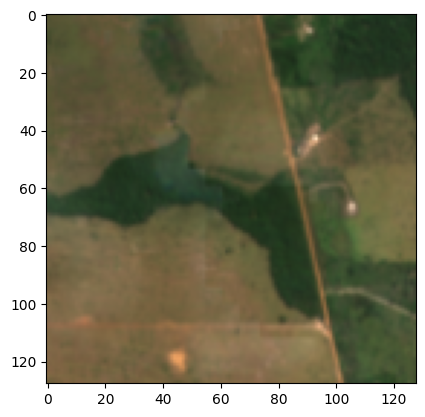

In [51]:
plt.imshow(np.transpose(image, (1, 2, 0))/image.max())
plt.show()

[0]


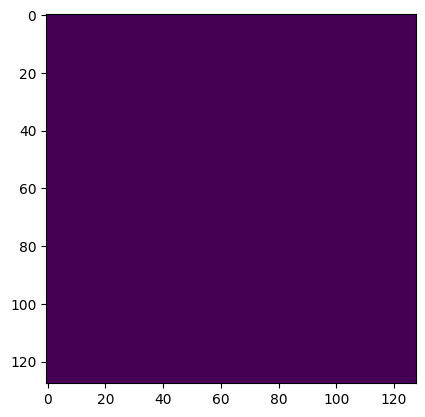

In [52]:
print(np.unique(label))
plt.imshow(label)
plt.show()

In [66]:
image_tensor = torch.as_tensor(image).to(device).unsqueeze(dim=0)
image_tensor.size()

torch.Size([1, 3, 128, 128])

In [67]:
model.eval()
pred = model(image_tensor)
pred = F.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

(1, 1, 128, 128)


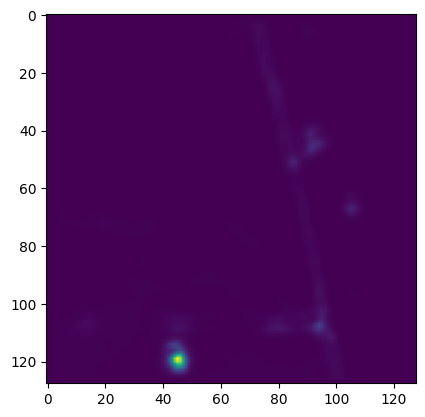

In [81]:
# pred = pred.numpy()
plt.imshow(pred[0, 0, :, :])
plt.show()

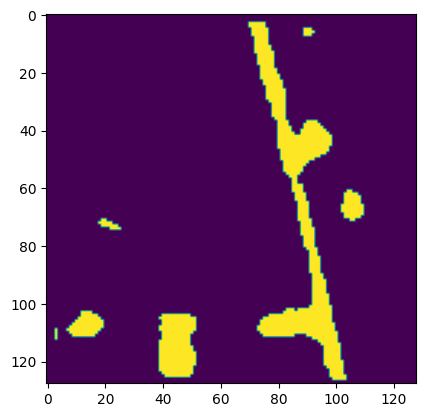

In [86]:
threshold = 0.00001
pred_thres = np.where(np.abs(pred) > threshold, 1, 0)
plt.imshow(pred_thres[0, 0, :, :])
plt.show()